# qanic Overview

In [39]:
# imports
import sys
sys.path.append('..')
import qanic as qa
import qutip as qt
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

## The Hamiltonian
We evolve the transverse-field Ising Hamiltonian used by [D-Wave](https://www.dwavesys.com/ "D-Wave homepage"),
#### $$H_{TFIM}(s) = \frac{A(s)}{2}\sum_i^N \sigma_i^x + \frac{B(s)}{2}\left(\sum_i^N h_i\sigma_i^z + \sum_{i<j}^N J_{ij}\sigma_i^z\sigma_j^z\right) = H_x(s) + H_z(s). $$

Optimization problems are encoded in $H_z$. However, we do not assume a native graph toplogy, so minor-embedding is not necessary.

# Evolution of $H_{TFIM}$ via s(t).
The evolution of $H_{TFIM}$ is highly constrained by hardware limitations. Specifically, the importance of the $H_z$ term with respect to the $H_x$ term is modulated by $B(s)/A(s)$ which itself is further limited by the allowed evolution of $s(t)$, the so-called "anneal schedule." In particular, $s(t)$ must obey the following rules
1. s(0) only has two starting values: 0 or 1. s(0) = 0 defines a forward anneal and s(0) = 1 defines a reverse anneal
2. s(T) = 1, an anneal must finish with s = 1 (T is the total anneal length)
3. s(t) must be piece-wise linear
4. s(t) cannot "zig-zag" too much. In particular, for a forward anneal s(t) must monotonically increase. For a reverse anneal, s(t) must monotoincally decrease until it reaches some s' and then it must monotically increase. That is, it can only swap directions once.
4. $M_1 \leq |\Delta s(t)/\Delta t| \leq M_2$ for chip-dependent min/max slopes $M_1$ and $M_2$

Note that these conditions imply the existence of a minimum and maximum anneal time, $T_{min}$ and $T_{max}$. To see this, consider a forward anneal that is linear (not piecewise) in $s(t)$. If the slope cannot be too large, then $s(T_{min})$ is the fastest anneal possible. Similarly, $s(T_{max})$ is the slowest anneal possible.

To make these ideas concrete, let's take a look at $A(s(t))$ and $B(s(t))$ for some different anneal schedules.

## A look at A(s) and B(s)

In [107]:
# the discrete definitions of A(s) and B(s) are stored in H
print(H.processor_data)

{'svals': array([0.   , 0.001, 0.002, ..., 0.998, 0.999, 1.   ]), 'Avals': array([9.104432e+00, 9.045368e+00, 8.986803e+00, ..., 3.458247e-06,
       3.300214e-06, 3.144497e-06]), 'Bvals': array([ 0.06677846,  0.06838301,  0.07000661, ..., 11.145     ,
       11.16561   , 11.18625   ])}


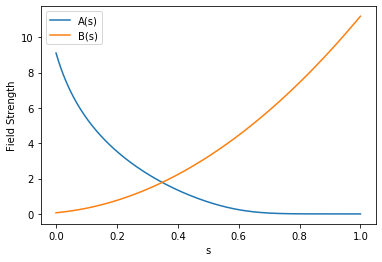

In [108]:
# now let's plot A and B as a function of s
# NOTE: The value of A and B at each s value is fixed by the device at any given time (subject to perturbations)
s, As, Bs = H.processor_data['svals'], H.processor_data['Avals'], H.processor_data['Bvals']
plt.plot(s, As, label='A(s)')
plt.plot(s, Bs, label='B(s)')
plt.legend()
plt.xlabel('s')
plt.ylabel('Field Strength')
plt.show()

## A Simple Forward Anneal Schedule

In [101]:
# anneal schedule is defined as a list of lists
T = 5
fsch = [[0, 0], [T, 1]]

# now we should discretize s(t)
# NOTE: this discretization is usually intenral to prob.IsingH, so it's usually not exposed to users--hence weird path
disc_fsch = qa.probrep.utils.make_numeric_schedule(fsch)
tvals, svals = disc_fsch
print(tvals[0:5])
print(svals[0:5])

[0.0, 0.0001, 0.0002, 0.00030000000000000003, 0.0004]
[0.0, 2e-05, 4e-05, 6.000000000000001e-05, 8e-05]


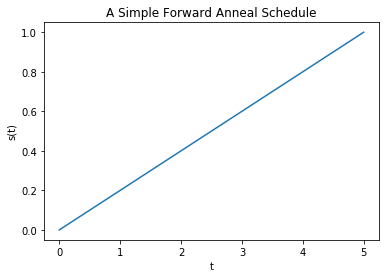

In [109]:
# now let's plot it
plt.plot(tvals, svals)
plt.title('A Simple Forward Anneal Schedule')
plt.xlabel('t')
plt.ylabel('s(t)')
plt.show()

In [103]:
# we can now associate a value of A and B for each value of t via s(t), the anneal schedule
fschAB = qa.probrep.utils.time_interpolation(disc_fsch, H.processor_data)
At, Bt = fschAB
print([At(0), At(2), At(5)])
print([Bt(0), Bt(2), Bt(5)])

[9.104432000000001, 1.345752, 3.1444970000000003e-06]
[0.06677846, 2.2287, 11.186250000000001]


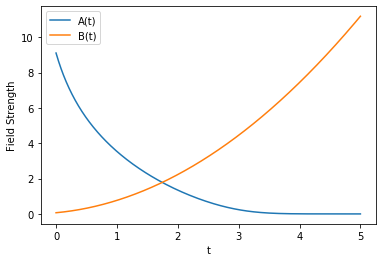

In [104]:
# we can now plot A(t) and B(t)
plt.plot(tvals, At(tvals), label='A(t)')
plt.plot(tvals, Bt(tvals), label='B(t)')
plt.legend()
plt.xlabel('t')
plt.ylabel('Field Strength')
plt.show()

Notice this looks exactly the same as $A(s)$ and $B(s)$ from before where the x-axis is scaled differently. For a simple linear forward anneal, this is exactly what we expect. However, different anneal lengths give rise to different values of $\frac{\mathrm{d}A(t)}{\mathrm{d}t}$. In particular, the longer the anneal time T, the smaller this derivative, and the more adiabatic the evolution.

## A Simple Reverse Anneal Schedule

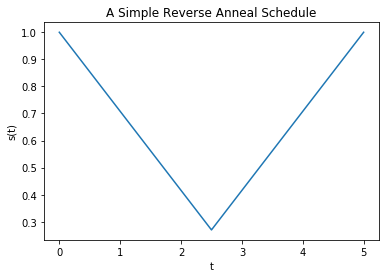

In [100]:
T, sp = 5, 0.27
rsch = [[0, 1], [T/2, sp], [T, 1]]
disc_rsch = qa.probrep.utils.make_numeric_schedule(rsch)
tvals, svals = disc_rsch
# now let's plot it
plt.plot(tvals, svals)
plt.title('A Simple Reverse Anneal Schedule')
plt.xlabel('t')
plt.ylabel('s(t)')
plt.show()

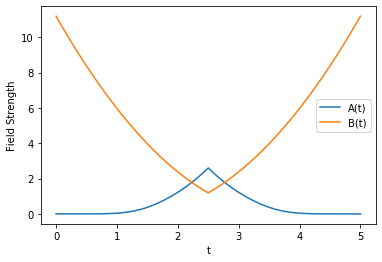

In [106]:
# we can now associate a value of A and B for each value of t via s(t), the anneal schedule
rschAB = qa.probrep.utils.time_interpolation(disc_rsch, H.processor_data)
At, Bt = rschAB
# we can now plot A(t) and B(t)
plt.plot(tvals, At(tvals), label='A(t)')
plt.plot(tvals, Bt(tvals), label='B(t)')
plt.legend()
plt.xlabel('t')
plt.ylabel('Field Strength')
plt.show()

In this case, A(t) and B(t) look quite different. This makes sense because s(t) no longer monotonically increases.

## A Bonus: Adding a Pause to the Reverse Anneal Schedule

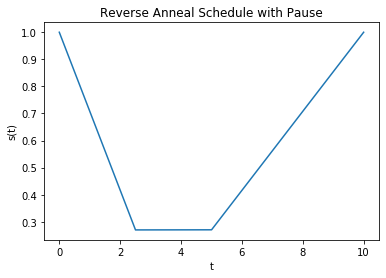

In [111]:
T, sp = 5, 0.27
rpsch = [[0, 1], [T/2, sp], [T, sp], [2*T, 1]]
disc_rpsch = qa.probrep.utils.make_numeric_schedule(rpsch)
tvals, svals = disc_rpsch
# now let's plot it
plt.plot(tvals, svals)
plt.title('Reverse Anneal Schedule with Pause')
plt.xlabel('t')
plt.ylabel('s(t)')
plt.show()

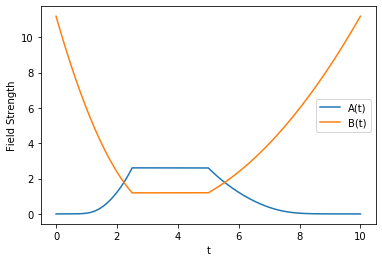

In [113]:
# we can now associate a value of A and B for each value of t via s(t), the anneal schedule
rpschAB = qa.probrep.utils.time_interpolation(disc_rpsch, H.processor_data)
At, Bt = rpschAB
# we can now plot A(t) and B(t)
plt.plot(tvals, At(tvals), label='A(t)')
plt.plot(tvals, Bt(tvals), label='B(t)')
plt.legend()
plt.xlabel('t')
plt.ylabel('Field Strength')
plt.show()

# Encoding $H_z$, internal represenation, and basic methods
To use our package, one must first encode $H_z$ into a dictionary (support for other inputs can be added easily if desired, but it's not a priory of ours). Then, dictH can be passed to the primary class of our package, IsingH. 

In [2]:
dictH = {(0, 0): 0, (1, 1): 0, (2, 2): 0,
        (0, 1): 1, (0, 2): 1, (1, 2): 1}
H = qa.IsingH(dictH, "K3")

## Internal $H_z$ representation via QuTiP
Our package uses [QuTiP](http://qutip.org/ "QuTiP homepage") as our "quantum backend." That is, QuTiP gives us an ecosystem to define Hamiltonians and wavefunctions that we can evolve with various solvers. Upon creating H, dictH is automatically mapped to the QuTiP version of $H_{TFIM}$ is automatically created.

In [3]:
# up to the A(s) / 2 constant, Hx for 3 qubits is defined as...
I, X = qt.identity(2), qt.sigmax()
Hx = qt.tensor(X, I, I) + qt.tensor(I, X, I) + qt.tensor(I, I, X)
print("Result of Hx == H.num_Hx is {}.".format(Hx == H.num_Hx))

Z = qt.sigmaz()
# we can ignore qubit-magnetic field interaction terms since h_i = 0 for all i
Hz = dictH[(0, 1)]*qt.tensor(Z, Z, I) + dictH[(0, 2)]*qt.tensor(Z, I, Z) + dictH[(1, 2)]*qt.tensor(I, Z, Z)
print("Result of Hz == H.num_Hz is {}.".format(Hz == H.num_Hz))

print(H.num_Hz)

Result of Hx == H.num_Hx is True.
Result of Hz == H.num_Hz is True.
Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[ 3.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  3.]]


## Simple Methods on H

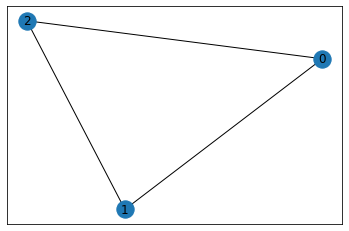

In [115]:
# this shows the connectively of the Hz graph
# NOTE: dist not to scale
H.visualize()

In [5]:
# we can diagonlize Hz using QuTiP
H.diag_Hz()

(array([-1., -1., -1., -1., -1., -1.,  3.,  3.]),
 array([Quantum object: dims = [[2, 2, 2], [1, 1, 1]], shape = (8, 1), type = ket
 Qobj data =
 [[0.]
  [1.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]],
        Quantum object: dims = [[2, 2, 2], [1, 1, 1]], shape = (8, 1), type = ket
 Qobj data =
 [[0.]
  [0.]
  [1.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]],
        Quantum object: dims = [[2, 2, 2], [1, 1, 1]], shape = (8, 1), type = ket
 Qobj data =
 [[0.]
  [0.]
  [0.]
  [1.]
  [0.]
  [0.]
  [0.]
  [0.]],
        Quantum object: dims = [[2, 2, 2], [1, 1, 1]], shape = (8, 1), type = ket
 Qobj data =
 [[0.]
  [0.]
  [0.]
  [0.]
  [1.]
  [0.]
  [0.]
  [0.]],
        Quantum object: dims = [[2, 2, 2], [1, 1, 1]], shape = (8, 1), type = ket
 Qobj data =
 [[0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [1.]
  [0.]
  [0.]],
        Quantum object: dims = [[2, 2, 2], [1, 1, 1]], shape = (8, 1), type = ket
 Qobj data =
 [[0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [1.]
  [0.]],
        Quantum object: dims = [

In [6]:
# however, QuTiP doesn't handle degenerate gs well, so
# we implemented our own function
gsinfo = H.Hz_gs_info(etol=1e-8, stol=1e-12)
print("GS state: {} with E: {}".format(gsinfo['gs'], gsinfo['E']))

GS state: [0.        +0.j 0.40824829+0.j 0.40824829+0.j 0.40824829+0.j
 0.40824829+0.j 0.40824829+0.j 0.40824829+0.j 0.        +0.j] with E: -1.0


In [7]:
# similarly, we can get the gs of H_TFIM(s=0)
H.dwaveH0_gs()

Quantum object: dims = [[2, 2, 2], [1, 1, 1]], shape = (8, 1), type = ket
Qobj data =
[[ 0.35161384]
 [-0.35419755]
 [-0.35419755]
 [ 0.35419755]
 [-0.35419755]
 [ 0.35419755]
 [ 0.35419755]
 [-0.35161384]]

We can recreate this ground-state in the expected way as an "equal superposition" among all the qubits

In [126]:
qt.tensor([X.groundstate()[1] for qubits in range(3)])

Quantum object: dims = [[2, 2, 2], [1, 1, 1]], shape = (8, 1), type = ket
Qobj data =
[[-0.35355339]
 [ 0.35355339]
 [ 0.35355339]
 [-0.35355339]
 [ 0.35355339]
 [-0.35355339]
 [-0.35355339]
 [ 0.35355339]]

There is a minor difference, of course, since $H_{TFIM}$ always contains both terms. That is, at $s = 0$, $A(0) >> B(0)$, but $B(0)$ is still not 0.

In [8]:
# or H_TFIM(s=1)
H.dwaveH1_gs()

Quantum object: dims = [[2, 2, 2], [1, 1, 1]], shape = (8, 1), type = ket
Qobj data =
[[ 8.60700868e-08]
 [-4.08248291e-01]
 [-4.08248290e-01]
 [ 4.08248290e-01]
 [-4.08248290e-01]
 [ 4.08248291e-01]
 [ 4.08248290e-01]
 [-8.60700867e-08]]

Notice that this is almost the same as the result of Hz_gs_info which performed direct diagonlizaiton. The minor error arises for the same reason as before: $A(s)$ and $B(s)$ are never actually 0.

# Numerical Annealing to obtain ground-state of $H_z$

There are two important numerical annealing methods on H: numeric_anneal and frem_anneal. In both cases, the the internals handle discretizing the input schedules, using this schedule to interpolate A(s(t)) and B(s(t)), and the, of course, solving $H_{TFIM}$ for the discretized times. The output is the final probability amplitudes of each state obtained from this process where the initial state is either a known ground-state or a user-supplied input state.

## Numeric Forward Anneal

In [167]:
# direct diag results for comparison
gsprobs = (gsinfo['gs']*gsinfo['gs'].conj()).real

In [142]:
# let's define a simple forward anneal schedule and see how the results scale with T
def fsch(T):
    return [[0, 0], [T, 1]]

# let's perform anneals of different lengths and compare the results to direct diagonlization
quick = H.numeric_anneal(fsch(0.1))
medium = H.numeric_anneal(fsch(1))
slow = H.numeric_anneal(fsch(10))
results = [quick, medium, slow]

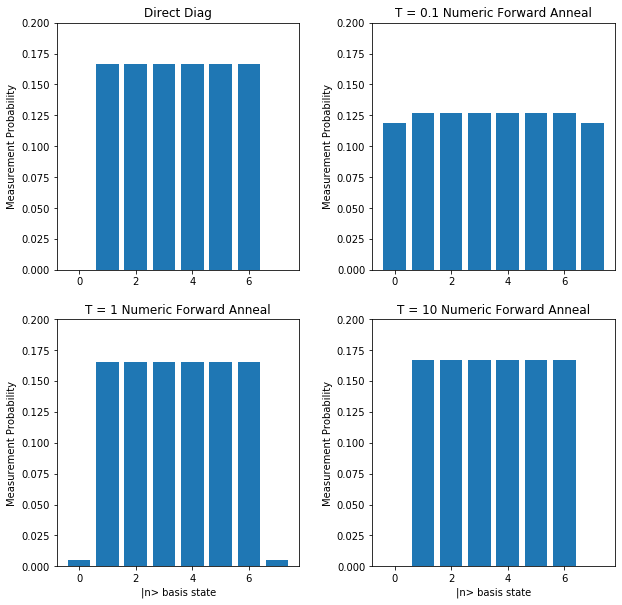

In [199]:
fig = plt.figure(figsize = (10, 10))
fig.subplots_adjust(hspace=0.2, wspace=0.3)
ylim = [0, 0.2]

fig.add_subplot(2, 2, 1)
plt.bar([0, 1, 2, 3, 4, 5, 6, 7], gsprobs.flatten())
plt.ylabel('Measurement Probability')
plt.title('Direct Diag')
plt.ylim(ylim)

fig.add_subplot(2, 2, 2)
plt.bar([0, 1, 2, 3, 4, 5, 6, 7], quick.flatten())
plt.ylabel('Measurement Probability')
plt.title('T = 0.1 Numeric Forward Anneal')
plt.ylim(ylim)

fig.add_subplot(2, 2, 3)
plt.bar([0, 1, 2, 3, 4, 5, 6, 7], medium.flatten())
plt.ylabel('Measurement Probability')
plt.xlabel('|n> basis state')
plt.title('T = 1 Numeric Forward Anneal')
plt.ylim(ylim)

fig.add_subplot(2, 2, 4)
plt.bar([0, 1, 2, 3, 4, 5, 6, 7], slow.flatten())
plt.ylabel('Measurement Probability')
plt.xlabel('|n> basis state')
plt.title('T = 10 Numeric Forward Anneal')
plt.ylim(ylim)
plt.show()

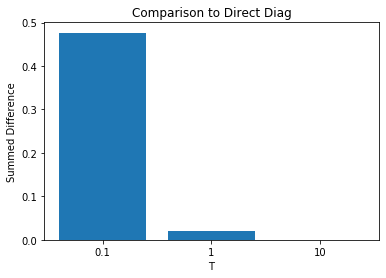

In [193]:
# Perhaps easier to see if a "total different" plot
diffs = [sum(abs(gsprobs - result)) for result in results]
plt.bar(["0.1", "1", "10"], diffs)
plt.ylabel('Summed Difference')
plt.xlabel('T')
plt.title('Comparison to Direct Diag')
plt.show()

## Reverse Anneal and FREM Anneal

At this point, the basics of the code have been brought to light. A reverse anneal protocol is hardly different than the forward above except that an initial state is requested alongside a valid reverse schedule, so we will leave it here from now. 

In regards to FREM, it is a new protocol that we are activley developing now, so we will leave experimental things out of the overview for now as well.